<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood, Sleep, and Daily Activity
Adding the final piece to the puzzle: self-reported sleep 

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.analysis import mood_prediction

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
from scipy import stats

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN

<a id='toc'></a>

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Clustering Analysis](#clustering_analysis)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)
5. [Saving](#saving)

---

<a id='data_import'></a>

# Data Import
We use the `ImportProcessing` to get the relevant data.

In [4]:
data = mood_prediction.ImportProcessing(data_dir="../data/")

In [5]:
data.mood_and_activity = data.remove_participant(data.mood_and_activity,"oxcpr7e3")

---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Score Distribution
To aid in binarizing the data more appropriately.

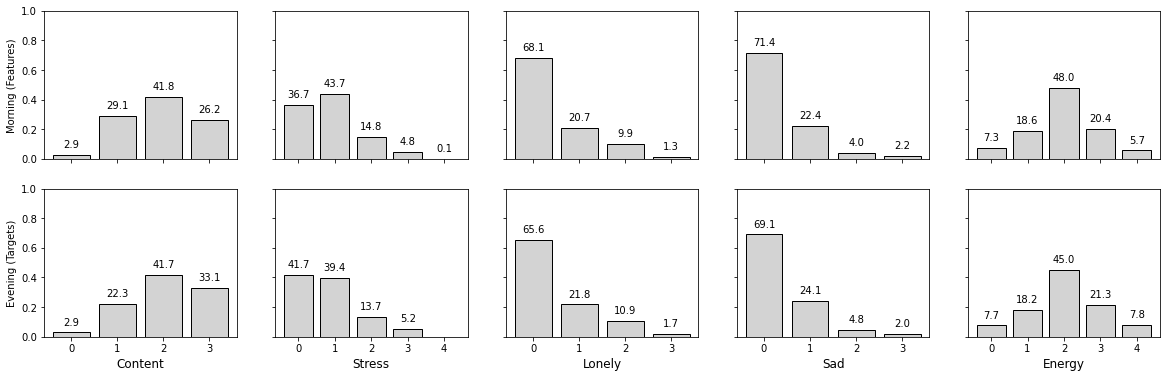

In [6]:
inspection = mood_prediction.Inspection()
_  = inspection.get_mood_distribution(data.mood_and_activity,plot=True)

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

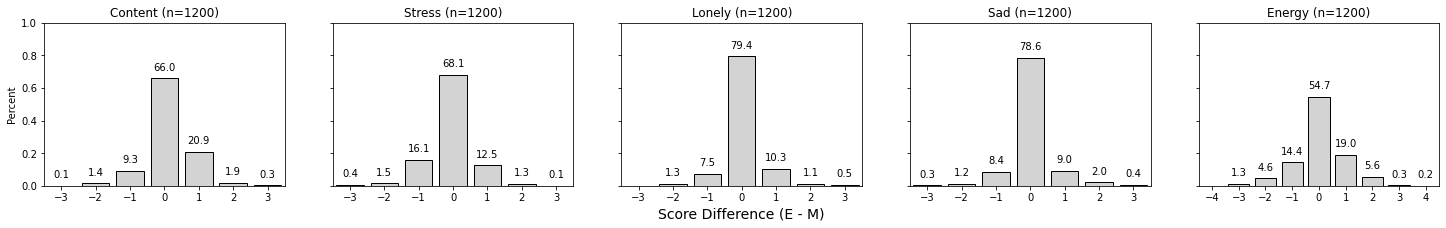

In [7]:
_ = inspection.get_mood_difference(data.mood_and_activity,plot=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

[Back to Inspection](#inspection)

---

<a id='clustering_analysis'></a>

[Back to ToC](#toc)
# Sleep Clustering Analysis
Since we cannot do a similar analysis to what we have done in the past with IEQ and activity data, we can try some newer, more advanced techniques.

Consider this [article](https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb) for a more robust way to cluster and analyze. 

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
def scale(df_in,scale_type="standard"):
    """
    Scales each row of the dataframe
    """
    df = df_in.copy()
    try:
        df.drop(["beiwe","date"],axis="columns",inplace=True)
    except KeyError:
        # colums not in dataframe
        pass
    df.dropna(inplace=True)
    if scale_type == "standard":
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(df)
    return scaler.transform(df)

In [10]:
def elbow(df_in):
    """
    Plots the inertia vs number of cluster for the elbow method
    """
    scores = [KMeans(n_clusters=i+2).fit(df_in).inertia_ 
              for i in range(10)]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(np.arange(2,12),scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel("Inertia")
    
    plt.show()
    plt.close()

In [11]:
def run_kmeans(df_in,k,scale_type="standard"):
    """
    Runs k-means clustering
    """
    df = df_in.copy()
    df.dropna(inplace=True)
    df_scaled = scale(df,scale_type=scale_type)
    clustering = KMeans(n_clusters=k).fit(df_scaled)
    df["label"] = clustering.labels_
    sc = silhouette_score(df, clustering.labels_,metric="euclidean")
    return df, sc

In [12]:
def run_dbscan(df_in,scale_type="standard",eps=0.5,min_samples=3):
    """
    Runs DBSCAN
    """
    df = df_in.copy()
    df.dropna(inplace=True)
    df_scaled = scale(df,scale_type=scale_type)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    df["label"] = clustering.labels_
    sc = silhouette_score(df, clustering.labels_,metric="cosine")
    return df, sc

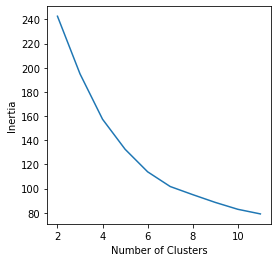

In [13]:
mood = "discontent"
data_to_use = data.mood_only[["tst","naw","sol","restful",f"{mood}_e"]]
data_scaled = scale(data_to_use,"minmax")
elbow(data_scaled)

In [14]:
res, sc = run_dbscan(data_to_use,scale_type="minmax",eps=0.25,min_samples=5)
sc

-0.18233536498478

In [15]:
res, sc = run_kmeans(data_to_use,k=5,scale_type="minmax")
sc

-0.08828928947454352

[Back to Clustering Analysis](#clustering_analysis)

---

<a id='modeling'></a>

# Modeling

In [16]:
modeling = mood_prediction.Model()

## Adding Features
We add the `step_goal` feature which determine whether or not the participant was able to reach the 10K (default) step goal.

In [17]:
data.mood_and_activity = modeling.binarize_steps(data.mood_and_activity)

In [18]:
data.mood_and_activity.head()

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,steps,distance,discontent_m,discontent_e,step_goal
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,4722.0,1.853799,2.0,1.0,0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,4199.0,1.720204,1.0,1.0,0
6,qh34m4r9,3.0,1.0,0.0,0.0,4.0,68,2020-05-13,3.0,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,11632.0,5.302906,0.0,0.0,1
8,tmexej5v,2.0,1.0,1.0,0.0,3.0,42,2020-05-13,2.0,1.0,1.0,0.0,3.0,6.0,15.0,0.0,2.0,521.0,0.202008,1.0,1.0,0
9,vpy1a985,2.0,1.0,2.0,1.0,2.0,50,2020-05-13,2.0,1.0,2.0,1.0,2.0,7.0,10.0,1.0,2.0,553.0,0.237737,1.0,1.0,0


## BIinarizing Datasets

In [19]:
data_bi = modeling.binarize_mood(data.mood_and_activity)
data_bi_targets = modeling.binarize_mood(data.mood_and_activity,binarize_features=False)

### Random Forest to Determine Feature Importance

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

#### GridSearch to Optimize RandomForest Parameters

In [21]:
def optimize_rfc(df_in,params,features=["tst","sol","restful","naw"],target_list=["discontent","sad","lonely","stress"]):
    """
    optimizes the paramters for the random forest classifier
    """
    df = df_in.copy()
    opt_RFC = GridSearchCV(RandomForestClassifier(),params,cv=5)
    for target in target_list:
        target = [f"{target}_e"]
        data_to_use = df[features + target].dropna()
        X = data_to_use[features]
        y = data_to_use[target]
        opt_RFC.fit(X,y)
        print(f"{target}:")
        for p, val in opt_RFC.best_params_.items():
            print(f"\t{p}:\t{val}")

In [22]:
params={"n_estimators":[2,5,10,20,100],"max_depth":[2,5,10],"min_samples_split":[2,3,4,5]}
optimize_rfc(data_bi,params)

['discontent_e']:
	max_depth:	5
	min_samples_split:	4
	n_estimators:	20
['sad_e']:
	max_depth:	2
	min_samples_split:	3
	n_estimators:	5
['lonely_e']:
	max_depth:	5
	min_samples_split:	2
	n_estimators:	100
['stress_e']:
	max_depth:	10
	min_samples_split:	5
	n_estimators:	100


In [23]:
def get_feature_importances(df_in,params,features=["tst","sol","restful","naw"],target_list=["discontent","sad","lonely","stress"],plot=True,verbose=False):
    """
    determines which of the features are most important for the random forest classifier
    """
    df = df_in.copy()
    res = {feature: [] for feature in features}
    res["mood"] = []
    for target in target_list:
        targets = [f"{target}_e"]
        data_to_use = df[features + targets].dropna()
        X = data_to_use[features]
        y = data_to_use[targets]
        clf = RandomForestClassifier(**params)
        output = cross_validate(clf, X, y, cv=5, scoring='accuracy', return_estimator =True)
        li =[]
        for idx,estimator in enumerate(output['estimator']):
            if verbose:
                print("Features sorted by their score for estimator {}:".format(idx))
                feature_importances = pd.DataFrame(estimator.feature_importances_,
                                                   index = X.columns,
                                                    columns=['importance']).sort_values('importance', ascending=False)
                print(feature_importances)
            li.append(estimator.feature_importances_)
            
        res["mood"].append(target)
        for key, value in zip(features,pd.DataFrame(li).mean()):
            res[key].append(value)
        
        if plot:
            fig, ax = plt.subplots(figsize=(2,1))
            ax.bar(X.columns,estimator.feature_importances_,color="lightgray",edgecolor="black")
            ax.set_ylim([0,0.5])
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            plt.show()
            plt.close()
            
    return res

In [24]:
opt_params = {"n_estimators":10,"max_depth":5,"min_samples_split":4}
test = get_feature_importances(data_bi,opt_params,plot=False)

In [25]:
pd.DataFrame(test)

,tst,sol,restful,naw,mood
0,0.247152,0.205438,0.411847,0.135563,discontent
1,0.257726,0.299112,0.229358,0.213804,sad
2,0.277877,0.356409,0.155539,0.210174,lonely
3,0.263016,0.276059,0.247386,0.213540,stress


## Comparing and Tuning Models
We test a slew of classification schemes to get the best model

### Defining Models and Hyperparameters to Tune
We use some common classifiers to predict the mood scores that should work for multi-class and binary outcomes.

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

### Multi-Class Classification

In [26]:
#opt_res = modeling.optimize_models(data.mood_and_activity,modeling.model_params,additional_features=["step_goal"])

In [27]:
#opt_res

The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 55.6 | 56.7     | 52.4                |

<div class="alert alert-block alert-info">
    
From this analysis, the models that we should consider are:
    
* Logistic Regression
* Support Vector
* Gradient Boost 
    
These models were the best-performing and operate on different principles which increases the diversity and strength of our results.
    
</div>

In [28]:
tuned_models = {"lr":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(probability=True,kernel="rbf"),
                "grad":GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=1,min_samples_leaf=2,min_samples_split=2)}
modeling.set_tuned_models(tuned_models)

#### Binary Classsification
We conduct two binary classification models to understand the effect of binarizing the mood features.

In [83]:
#opt_res_binary = modeling.optimize_models(data_bi,modeling.model_params,additional_features=["step_goal"])

	Random Forest
		Elapsed Time:	 0:00:19.842987
		Best Score:	79.0
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Svc
		Elapsed Time:	 0:00:00.622056
		Best Score:	80.3
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:00:12.825590
		Best Score:	80.9
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Logistic Regression
		Elapsed Time:	 0:00:00.154385
		Best Score:	80.3
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:23.849009
		Best Score:	81.3
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Svc
		Elapsed Time:	 0:00:00.868476
		Best Score:	81.3
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:00:15.848893
		Best Score:	81.4
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Logistic Regression
		El

In [29]:
#opt_res_binary

The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 55.6 | 56.7     | 52.4                |

In [85]:
#opt_res_binary_2 = modeling.optimize_models(data_bi_targets,modeling.model_params,additional_features=["step_goal"])

	Random Forest
		Elapsed Time:	 0:00:19.412598
		Best Score:	79.9
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Svc
		Elapsed Time:	 0:00:00.660510
		Best Score:	80.3
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:00:14.699207
		Best Score:	79.5
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Logistic Regression
		Elapsed Time:	 0:00:00.100917
		Best Score:	78.8
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:22.221775
		Best Score:	81.7
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Svc
		Elapsed Time:	 0:00:00.778840
		Best Score:	81.5
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:00:13.592168
		Best Score:	81.5
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Logistic Regression
		El

In [30]:
#opt_res_binary_2

<div class="alert alert-block alert-info">
    
From this analysis, we consider the same models as before despite random forest performing equally as well:
    
* Logistic Regression
* Support Vector
* Gradient Boost
    
</div>

In [31]:
tuned_models_bi = {"lr":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(probability=True,kernel="linear"),
                "grad":GradientBoostingClassifier(random_state=42,n_estimators=10,max_depth=1,min_samples_leaf=1,min_samples_split=2)}
modeling.set_tuned_models_bi(tuned_models_bi)

## Cross-Validation
We will use three different techniques of cross-validation to compare and understand the sensitivity of our models to different sets of the data:
1. **Stratified K-Fold**: This method will ensure that the same ratio of the target classes are preserved which is important especially considering we have four classes in this instance compared to our binary evaluations in the past.
2. **Group K-Fold**: This method will help test the sensitivity to any particular participant groups.
3. **Leave One Group Out**: The most extreme method to understand the sensitivity of the model to a particular participant.

In [32]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, LeaveOneGroupOut, cross_val_score

In [33]:
def cross_validate(df,models,cv_label="skf",moods=["content","stress","lonely","sad","energy"],n_splits=5,verbose=False):
    """
    Runs various cross-validation techniques on the provided models
    
    Parameters
    ----------
    df : DataFrame
    models : dict
        sklearn ML models to consider with keys corresponding to the string of the model name and the keys of the sklearn
        model with provided hyperparameters
    cv_label : {"skf","gkf","logo"}, default "skf"
        Specifies the type of cross-validation technique:
        "skf":stratified k-fold, "gkf":group k-fold, "logo":leave one group out
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    n_splits : int, default 5
        number of splits to perform for k-fold cross-validation techniques
    verbose : boolean, default False
        verbose mode for debugging primarily leave one group out cross-validation
    
    Returns
    -------
    <results> : DataFrame
        Cross-validation scores from each split and the average per each mood and model
    """
    if cv_label == "skf":
        cv = StratifiedKFold(n_splits=n_splits)
        groups = None # for consistency
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "gkf":
        cv = GroupKFold(n_splits=n_splits)
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "logo":
        cv = LeaveOneGroupOut()
        X,y,groups = get_x_and_y(df)
        if verbose:
            for train_index, test_index in cv.split(X, y, groups):
                print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = groups.iloc[train_index], groups.iloc[test_index]
                print(X_train, X_test)
        res = {key: [] for key in ["mood","model"] + [f"{pt} ({n})" for pt, n in zip(groups.unique(),groups.value_counts().sort_index())] + ["mean"]}
    else:
        raise NameError(f"{cv_label} is an invalid option - choose one of ['skf','gkf','logo']")
        
    for mood in moods:
        for model in models.keys():
            X, y, groups = get_x_and_y(df,mood=mood)
            clf = models[model]
            scores = cross_val_score(clf, X, y, cv=cv, groups=groups)
            values = [mood,model]+list(scores)+[np.mean(scores)]
            for key, value in zip(res.keys(),values):
                res[key].append(value)
                
    return pd.DataFrame(data=res)

### Results: Stratified K-Fold

In [34]:
#res_skf = cross_validate(data,tuned_models,cv_label="skf")
#res_skf

<div class="alert alert-block alert-success">
    
Models tend to be rather consistent amongst the various splits - varying by ~0.5 at the most.
    
</div>

### Group K-Fold

In [35]:
#res_gkf = cross_validate(data,tuned_models,cv_label="gkf")
#res_gkf

<div class="alert alert-block alert-success">
    
Similar results to the stratified split both in terms of variation and average scores.
    
</div>

In [36]:
#res_logo = cross_validate(data,tuned_models,cv_label="logo")
#res_logo

<div class="alert alert-block alert-warning">
    
The scores vary widely most likely influenced by the number of datapoints that each participant provides. If those values are low, then the results could either be very _low_ indicating dramatically different responses are very _high_ indicating the same response. Further scrutiny is warranted and condcuted in the [Inspection](#inspection) section.
    
</div>

# Prediction
Since our models seemed to pass the test with the cross-validation, now we can use them to predict the outcomes. 

In [37]:
predictor = mood_prediction.Prediction()

In [38]:
def get_predictions(df,mood,model,probability=False, include_evening=False):
    """
    Gets the predictions for the given mood
    
    """
    X, y, _ = get_x_and_y(df,mood,include_evening=include_evening,additional_features=additional_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = model.fit(X_train,y_train)
    
    if probability:
        pred = clf.predict_proba(X_test)[:, 1]
    else:
        pred = clf.predict(X_test)
    return y_test, pred

In [39]:
data_bi

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,steps,distance,discontent_m,discontent_e,step_goal
2,rvhdl2la,1,1,0,0,0,29,2020-05-13,0,1,1,1,0,5.3,5.0,2.0,2.0,4722.0,1.853799,1,1,0
4,xdbdrk6e,1,1,1,1,1,23,2020-05-13,1,1,1,1,1,8.0,20.0,3.0,2.0,4199.0,1.720204,1,1,0
6,qh34m4r9,1,1,0,0,1,68,2020-05-13,1,0,0,0,0,8.0,20.0,2.0,3.0,11632.0,5.302906,0,0,1
8,tmexej5v,1,1,1,0,1,42,2020-05-13,1,1,1,0,1,6.0,15.0,0.0,2.0,521.0,0.202008,1,1,0
9,vpy1a985,1,1,1,1,1,50,2020-05-13,1,1,1,1,1,7.0,10.0,1.0,2.0,553.0,0.237737,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,7dhu3pn7,1,1,0,0,1,64,2020-09-01,1,1,0,0,1,8.0,5.0,0.0,3.0,3775.0,1.517451,1,0,0
2145,745vq78e,1,0,0,0,1,55,2020-09-01,1,0,0,0,1,7.6,0.0,1.0,2.0,723.0,0.280425,0,0,0
2146,rkem5aou,1,1,1,1,1,85,2020-09-01,1,1,1,1,1,6.0,10.0,0.0,2.0,1742.0,0.684192,1,1,0
2147,axk49ssu,1,1,0,1,0,52,2020-09-01,1,1,0,1,0,7.0,40.0,3.0,1.0,3333.0,1.425239,1,1,0


In [42]:
y_true, y_pred = predictor.get_predictions(data_bi,mood="content",model=modeling.tuned_models["lr"],include_evening=False,additional_features=["step_goal"])

# Evaluation
[Here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) is a nice article regarding various metrics to consider.

In [43]:
evaluator = mood_prediction.Evaluation()

## Confusion Matrices
We can look at how well our models perform by considering the confusion matrices.

In [44]:
def get_cm(y_true,y_pred,plot=False):
    """
    Returns confusion matrix
    
    Parameters
    ----------
    y_true : list
        the actual values
    y_pred : list
        the predicted values
    plot : boolean
        whether or not to dispaly the confusion matrices
        
    Returns
    -------
    cm : list of lists
        the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if plot:
        _, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(pd.DataFrame(cm),vmin=0,
                    linecolor="black",linewidth=1,cmap="viridis",     
                    square=True,annot=True,fmt='d',ax=ax)
        ax.set_xticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_xlabel("Predicted Value",fontsize=14)
        ax.set_yticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_ylabel("True Value",fontsize=14)
        plt.show()
        plt.close()
    
    return cm

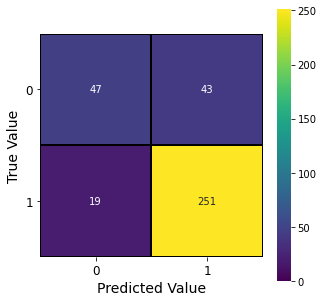

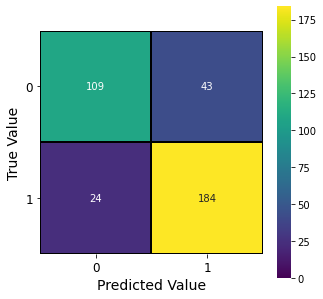

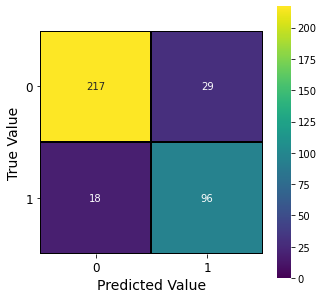

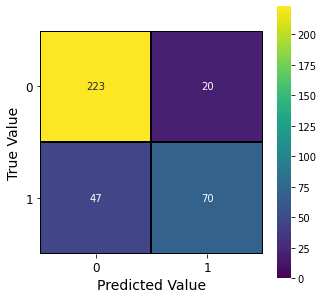

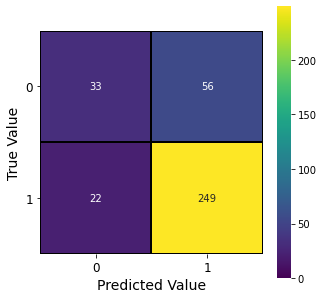

In [46]:
for mood in ["content","stress","lonely","sad","energy"]:
    y_true, y_pred = predictor.get_predictions(data_bi,mood,tuned_models["lr"],include_evening=True,additional_features=["step_goal"])
    _ = evaluator.get_cm(y_true, y_pred, plot=True)

### Defining the Confusion Matrix
* **Positive Classes**: 2 and 3
* **Negative Classes**: 0 and 1

## All the metrics
Who knew there was a fancy function for all this? In addition, we borrow some advice from the TDS crew.

In [47]:
evaluator.get_scoring_metrics(data_bi,tuned_models["lr"],include_evening=False,additional_features=["step_goal"])

ValueError: y should be a 1d array, got an array of shape (360, 2) instead.

In [48]:
evaluator.get_scoring_metrics(data_bi,tuned_models["lr"],include_evening=True,additional_features=["step_goal"])

ValueError: y should be a 1d array, got an array of shape (360, 2) instead.

In [49]:
def get_report(df,model,mood="content"):
    """
    Gets the classification report and prints it
    
    """
    y_true, y_pred = get_predictions(df,mood,model)
    print(mood)
    print(classification_report(y_true, y_pred))

In [51]:
get_report(data,tuned_models["lr"],"lonely")

NameError: name 'get_x_and_y' is not defined

[Back to Evaluation](#evaluation)

---

# Saving

## Results

In [ ]:
with pd.ExcelWriter('../data/interim/mood_prediction/results-mood_and_activity_on_mood.xlsx') as writer:  
    for model,model_bi in zip(modeling.tuned_models.keys(),modeling.tuned_models_bi.keys()):
        for include_evening in [False,True]:
            print(f"{model.upper()} - Include Evening: {include_evening}")
            print("\tMulticlass")
            res = evaluator.get_scoring_metrics(data.mood_and_activity,modeling.tuned_models[model],include_evening=include_evening,additional_features=["step_goal"])
            res.to_excel(writer, sheet_name=f"{model}-multiclass-evening_{str(include_evening).lower()}")
            print("\tBinary")
            res_bi = evaluator.get_scoring_metrics(data_bi,modeling.tuned_models_bi[model_bi],binary=True,include_evening=include_evening,additional_features=["step_goal"])
            res_bi.to_excel(writer, sheet_name=f"{model}-binary-evening_{str(include_evening).lower()}")

LR - Include Evening: False
	Multiclass
	Binary
LR - Include Evening: True
	Multiclass
	Binary
SVC - Include Evening: False
	Multiclass
	Binary
SVC - Include Evening: True
	Multiclass
	Binary
GRAD - Include Evening: False
	Multiclass


[Back to Top](#top)